# Actividad: Modelización y resolución con Dwave

## Objetivos

El objetivo de esta actividad será construir un modelo capaz de resolver de forma sencilla el problema del viajante.

Se partirá del siguiente mapa:
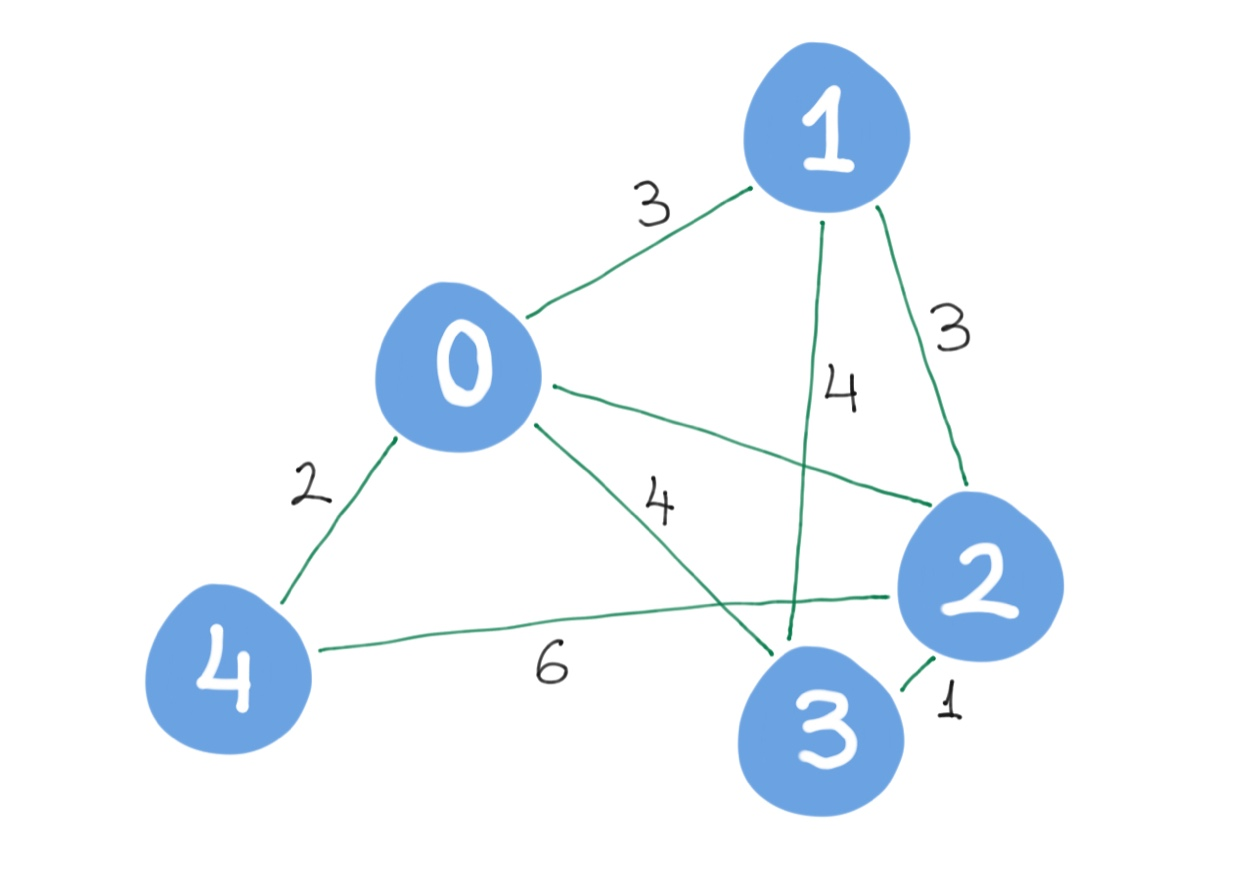


Cada uno de estos nodos representa una ciudad que, como podemos ver, están unidas a través de una serie de carreteras (nótese que no tienen por qué existir carreteras entre todas las ciudades).

El objetivo será encontrar la ruta de mínima distancia que cumpla las siguientes características:

- El inicio de la ruta y el final debe ser el nodo 0.
- La segunda ciudad que vamos a visitar (sin contar el origen) debe ser la ciudad 2.
- Todas las ciudades deben ser visitadas.
- Solo podemos ir una vez a cada una de las ciudades.

Como podemos ver, no se ha indicado la distancia del nodo 0 al nodo 2. Da a dicha distancia la longitud que te parezca más acertada.

Por otro lado, la solución que ofrece DWave será una serie de unos y ceros. Tendrás que programar una función capaz de traducir ese dominio de solución a una lista con el número de las ciudades por orden de visita. 

## Librerías

Instalamos las librerías necesarias para conectarnos a Dwave

In [40]:
%pip install dwave-ocean-sdk dwave_networkx

Las librerías que necesitamos son:
- networkx: Esta biblioteca es utilizada para la creación, manipulación y análisis de grafos en Python. Proporciona estructuras de datos para representar diferentes tipos de redes, así como algoritmos para analizarlas.
- dwave_networkx: Esta extensión de NetworkX está diseñada específicamente para trabajar con grafos en el contexto de la computación cuántica y los sistemas D-Wave. Ofrece funciones adicionales para resolver problemas de optimización utilizando técnicas cuánticas como el Anillado Cuántico.

In [41]:
import networkx as nx
import dwave_networkx as dnx
from neal import SimulatedAnnealingSampler

## Ejecución

Definimos los parámetros para que se cumplan los siguientes puntos:

- El inicio de la ruta y el final debe ser el nodo 0.
- La segunda ciudad que vamos a visitar (sin contar el origen) debe ser la ciudad 2.
- Definimos la distancia del 0 al 2 como x y probamos con 4.

In [42]:
start = 0
second_city = 2
x = 4

Definimos el grafo, el sampler a utilizar, el número de samples y un coeficiente de Lagrange.

In [43]:
graph = {
    (0, 1, 3),
    (0, 2, x),
    (0, 3, 4),
    (0, 4, 2),
    (1, 2, 3),
    (1, 3, 4),
    (2, 4, 6),
}

sampler = SimulatedAnnealingSampler()
n_samples = 100
lagrange = 10

Creamos un grafo a partir de los datos proporcionados

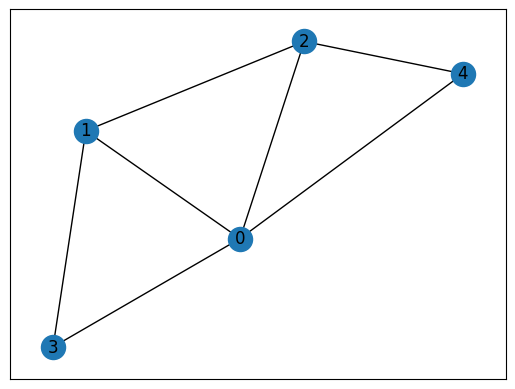

In [44]:
G = nx.Graph()
G.add_weighted_edges_from(graph)
nx.draw_networkx(G)

Generamos el problema QUBO basado en el grafo

In [45]:
Q = dnx.traveling_salesperson_qubo(G, lagrange=lagrange)

Penalizamos los nodos que no son el inicio o la segunda ciudad en el tiempo correspondiente

In [46]:
for node in G:
  if node != start:
    Q[((node, 0), (node, 0))] = 2*lagrange
  if node != second_city:
    Q[((node, 2), (node, 2))] = 2*lagrange

Resolvemos el problema QUBO utilizando el sampler proporcionado

In [47]:
sampleset = sampler.sample_qubo(Q, num_reads = n_samples)
solution = sampleset.first.sample

Obtenemos la ruta óptima del vendedor viajero a partir de la solución. 

Dado que la formulación del problema QUBO garantiza que cada ciudad sea visitada exactamente una vez, la solución resultante contendrá exactamente una variable igual a 1 para cada ciudad visitada en la ruta óptima del vendedor viajero. 

In [48]:
path = {key: value for key, value in solution.items() if value == 1}

Reconstruimos la ruta a partir de la solución

In [49]:
route = [None]*len(path)
for (city, time), val in path.items():
  if val:
    route[time] = city

Encontramos la ruta óptima:

In [50]:
print("Optimal Route: ", route)

Optimal Route:  [0, 4, 2, 1, 3]


Calculamos el coste total de la ruta óptima:

In [51]:
def calculate_total_cost(graph, route):
    """
    Calculate the total cost of the given route in the graph.

    Args:
    - graph (set): The graph represented as a set of tuples, each tuple containing three elements: (node1, node2, weight).
    - route (list): The route to calculate the total cost for, represented as a list of city indices.

    Returns:
    - int: The total cost of the route in the graph.
    """
    total_cost = 0
    for i in range(len(route) - 1):
        current_city = route[i]
        next_city = route[i + 1]
        for edge in graph:
            if (edge[0] == current_city and edge[1] == next_city) or (edge[0] == next_city and edge[1] == current_city):
                total_cost += edge[2]  # Add the weight of the edge
                break
    return total_cost


calculate_total_cost(graph, route)

15

## Probando parámetros

Encapsulamos el problema en una función para probar con diferentes valores de Lagrange y X. Creamos una función para reemplazar el valor del grafo que falta por el valor dado:

In [52]:
def replace_x_in_graph(graph, x):
    """
    Replace occurrences of 'x' in the weights of edges in the graph with a given number.

    Args:
    - graph (set): The graph represented as a set of tuples, each tuple containing three elements: (node1, node2, weight).
    - x: The number to replace 'x' with in the graph.

    Returns:
    - set: The updated graph with 'x' replaced by the given number.
    """
    updated_graph = set()
    for edge in graph:
        if edge[2] == 'x':
            updated_graph.add((edge[0], edge[1], x))
        else:
            updated_graph.add(edge)
    return updated_graph


Y la función que encapsula el problema:

In [64]:
def TSP(graph, lagrange, missing_edge_weight, sampler=SimulatedAnnealingSampler(), n_samples=100):
    """
    Solve the Traveling Salesperson Problem (TSP) using Quantum Annealing.

    Args:
    - graph (set): The weighted edges of the graph. Each edge should be represented as a tuple (node1, node2, weight).
    - lagrange (float): Lagrange parameter for QUBO problem formulation.
    - missing_edge_weight: Weight assigned to missing edges in the graph.
    - sampler (dimod.Sampler): Sampler for solving the QUBO problem. Default is SimulatedAnnealingSampler.
    - n_samples (int): Number of samples for the quantum annealer.

    Returns:
    - tuple: A tuple containing the optimal route found by the solver and its cost.
    """
    graph = replace_x_in_graph(graph, missing_edge_weight)
    G = nx.Graph()
    G.add_weighted_edges_from(graph)
    Q = dnx.traveling_salesperson_qubo(G, lagrange=lagrange)

    for node in G:
        if node != start:
            Q[((node, 0), (node, 0))] = 2*lagrange
        if node != second_city:
            Q[((node, 2), (node, 2))] = 2*lagrange

    sampleset = sampler.sample_qubo(Q, num_reads=n_samples)
    solution = sampleset.first.sample
    path = {key: value for key, value in solution.items() if value == 1}
    route = [None] * len(path)

    try:
        for (city, time), val in path.items():
            if val:
                route[time] = city
    except:
        return None, None
    
    cost = calculate_total_cost(graph, route)
    return route, cost


Probamos los rangos de 10 para cada X y cada Lagrange:

In [65]:
graph = {
    (0, 1, 3),
    (0, 2, 'x'),
    (0, 3, 4),
    (0, 4, 2),
    (1, 2, 3),
    (1, 3, 4),
    (2, 4, 6),
}

solutions = []

for x in range(1, 10):
    for l in range(1, 10):
        route, cost = TSP(graph, l, x)
        solutions.append([x, l, route, cost])

Podemos ver que para los parámetros que hemos establecido, tenemos diversas soluciones óptimas para el problema.

In [66]:
import pandas as pd

df = pd.DataFrame(solutions, columns=['X', 'Lagrange', 'Route', 'Cost'])
df = df[df['Route'].notna()]
df

,X,Lagrange,Route,Cost
6,1,7,"[0, 4, 2, 1, 3]",15.0
7,1,8,"[0, 4, 2, 1, 3]",15.0
8,1,9,"[0, 4, 2, 1, 3]",15.0
15,2,7,"[0, 4, 2, 1, 3]",15.0
16,2,8,"[0, 4, 2, 1, 3]",15.0
17,2,9,"[0, 4, 2, 1, 3]",15.0
23,3,6,"[0, 4, 2, 1, 3]",15.0
24,3,7,"[0, 4, 2, 1, 3]",15.0
25,3,8,"[0, 4, 2, 1, 3]",15.0
26,3,9,"[0, 4, 2, 1, 3]",15.0
